# Import Statements

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cpu


# Loading the FashhionMNIST Dataset

Run all code blocks in: ([`hw3-dataprep.ipynb`](hw3-dataprep.ipynb)) to download and prepare the dataset.

---

## Dataset Loader

In [3]:
from hw3_FashionMNISTDataset import FashionMNISTDataset
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os

In [4]:
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
BATCH_SIZE = 128

In [7]:
train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files/',
                                    transform=custom_train_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid.csv',
                                    img_dir='png-files/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test.csv',
                                   img_dir='png-files/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [8]:
# Checks that the dataset has been properly loaded

torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
break minibatch for-loop


# MLP-CNN Model

In [56]:
class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.conv_layer_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu_layer_1 = torch.nn.ReLU()
        self.pooling_layer_1 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv_layer_2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu_layer_2 = torch.nn.ReLU()
        self.pooling_layer_2 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv_layer_3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu_layer_3 = torch.nn.ReLU()
        self.pooling_layer_3 = torch.nn.MaxPool2d(kernel_size=2)


        self.relu_layer_1 = torch.nn.ReLU()
        self.pooling_layer_1 = torch.nn.MaxPool2d(kernel_size=2)

        self.softmax = torch.nn.Softmax()

        self.linear_layer_1 = torch.nn.Linear(1024, 1024)
        self.relu_layer_4 = torch.nn.ReLU()

        self.linear_layer_2 = torch.nn.Linear(1024, 10)
        
    def forward(self, x):
        out = self.conv_layer_1(x)
        out = self.relu_layer_1(out)
        out = self.pooling_layer_1(out)

        out = self.conv_layer_2(out)
        out = self.relu_layer_2(out)
        out = self.pooling_layer_2(out)

        out = self.conv_layer_3(out)
        out = self.relu_layer_3(out)
        out = self.pooling_layer_3(out)


        out = out.view(-1, 1024)

        out = self.linear_layer_1(out)
        out = self.relu_layer_4(out)
        
        logits = self.linear_layer_2(out)
        probas = self.softmax(logits)
        
        return logits, probas

    
#################################
### Model Initialization
#################################
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
model = MLP()
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9, nesterov=True)
NUM_EPOCHS = 20

In [59]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(DEVICE)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        optimizer.step()

        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/429 | Cost: 2.3044
Epoch: 001/020 | Batch 020/429 | Cost: 2.2592
Epoch: 001/020 | Batch 040/429 | Cost: 1.8348
Epoch: 001/020 | Batch 060/429 | Cost: 1.0932
Epoch: 001/020 | Batch 080/429 | Cost: 0.9408
Epoch: 001/020 | Batch 100/429 | Cost: 0.8198
Epoch: 001/020 | Batch 120/429 | Cost: 0.6499
Epoch: 001/020 | Batch 140/429 | Cost: 0.4906
Epoch: 001/020 | Batch 160/429 | Cost: 0.6040
Epoch: 001/020 | Batch 180/429 | Cost: 0.6527
Epoch: 001/020 | Batch 200/429 | Cost: 0.5836
Epoch: 001/020 | Batch 220/429 | Cost: 0.6282
Epoch: 001/020 | Batch 240/429 | Cost: 0.5011
Epoch: 001/020 | Batch 260/429 | Cost: 0.4521
Epoch: 001/020 | Batch 280/429 | Cost: 0.4639
Epoch: 001/020 | Batch 300/429 | Cost: 0.4250
Epoch: 001/020 | Batch 320/429 | Cost: 0.5291
Epoch: 001/020 | Batch 340/429 | Cost: 0.6006
Epoch: 001/020 | Batch 360/429 | Cost: 0.5065
Epoch: 001/020 | Batch 380/429 | Cost: 0.5530
Epoch: 001/020 | Batch 400/429 | Cost: 0.4646
Epoch: 001/020 | Batch 420/429 | C

# Evaluation

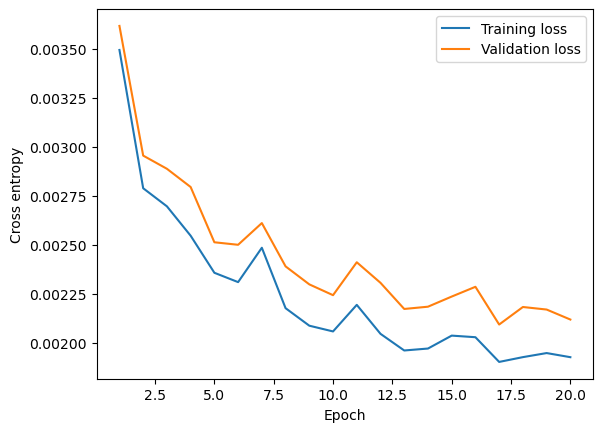

In [62]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

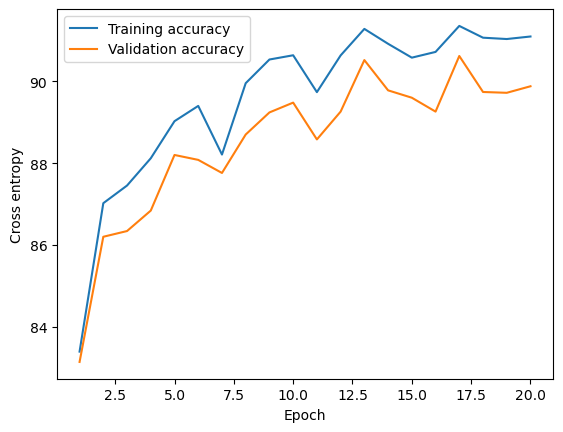

In [63]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [64]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')